# 5. Explanation of Predictions

Since the focus of this project is on interpretable ML, we will explain our predictions in the following chapter. Explanation in Machine Learning can be translated to understanding how a trained model works and how it does its predictions. This more precisely means, understanding how the model weighs the different features that were trained to it and how those features have an impact on the actual prediction. Understanding a model will lead to the decision whether a model can be trusted or not.

As an example, I would like you to imagine that you share your Netflix or Spotify Account with someone else. Maybe you don't even need to imagine. :-) However, Netflix as well as Spotify base their recommendations on a model, that is trained by what you are consuming. For example, you like to watch a lot of romances, but sometimes your sister is watching action thrillers with your account. Netflix recommends a new action thriller to you and will state it as "something you like". But actually, you don't like it. Since you know that this recommendation is based on what your sister is sometimes watching with your Netflix account, you will not watch this recommendation. At this point you were actually explaining the prediction of the model that Netflix uses to give you recommendations and you found out that they are biased by your sister and for this reason you're not trusting it. Therefore, you might not only change your password so your sister will not bias your recommendations anymore, but you will also be happy since you understood what explanation of prediction means.

Sadly, for the models of this project it is not that easy, because finding out if we can trust our model or not, is a bit more complicated, since it has more than just 1 component to consider. In order to explain the predictions of our models, we will use the Permutation importance and PDPs as a global measure for how important features are and SHAP to have a closer look into single predictions.

Before we can start, we need to load and prepare the data as well as fitting our models again. Executing the code for this notebook can take up to 20 minutes, depending on the power of your machine.

In [44]:
#import all libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap

In [2]:
df = pd.read_json('data/train.json')
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


Apply changes from data cleaning and feature engineering to dataframe.

In [3]:
#drop outliers (from data cleaning)
df = df[(df['bathrooms'] != 0) | (df['bathrooms'] != 10)]
df = df[df['bedrooms'] <= 6]
df = df[df['building_id'].str.len() >= 32]
df = df[df['price'] < 1000000]

In [4]:
#feature engineering photos
df =df.copy()
df['num_photos'] = df['photos'].apply(len)
df['num_features'] = df['features'].apply(len)
df['num_description_words'] = df['description'].apply(lambda x: len(x.split(' ')))

In [5]:
#feature engineering features
df['features_new'] = df["features"].apply(lambda y: " ".join(["_".join(x.split(" ")).lower() for x in y]))

def add_feature(row):
    if re.search(r'hardwood',row['features_new'],re.IGNORECASE)!=None:
        row['hardwood']=1
    else:
        row['hardwood']=0
        
    if re.search(r'doorman',row['features_new'],re.IGNORECASE)!=None:
        row['doorman']=1
    else:
        row['doorman']=0
    
    if re.search(r'fee',row['features_new'],re.IGNORECASE)!=None:
        row['fee']=1
    else:
        row['fee']=0
    
    if re.search(r'cats',row['features_new'],re.IGNORECASE)!=None:
        row['cats']=1
    else:
        row['cats']=0

    if re.search(r'laundry',row['features_new'],re.IGNORECASE)!=None:
        row['laundry']=1
    else:
        row['laundry']=0

    if re.search(r'war\Z|war\s|war_',row['features_new'],re.IGNORECASE)!=None: #makes sure that "war" is only connected to "pre" and "post" and not just included in a word like "wardrobe"
        row['war']=1
    else:
        row['war']=0

    if re.search(r'fitness',row['features_new'],re.IGNORECASE)!=None:
        row['fitness']=1
    else:
        row['fitness']=0
        
    if re.search(r'elevator',row['features_new'],re.IGNORECASE)!=None:
        row['elevator']=1
    else:
        row['elevator']=0
        
    if re.search(r'dishwasher',row['features_new'],re.IGNORECASE)!=None:
        row['dishwasher']=1
    else:
        row['dishwasher']=0
        
    if re.search(r'dogs',row['features_new'],re.IGNORECASE)!=None:
        row['dogs']=1
    else:
        row['dogs']=0
        
    return row

df=df.apply(add_feature,axis=1)

In [6]:
#feature engineering longitude and lattitude
addresssplit = pd.read_csv('data/addresshousing.csv')
addresssplit=pd.concat([addresssplit, addresssplit['address'].str.split(', ', expand=True)], axis=1)
df1=addresssplit.rename({0:'Streetnumber',1:'Streetname',2:'neighbourhood',3:'Community'}, axis='columns')
df1=df1[['building_id','interest_level', 'price','listing_id','Streetnumber','Streetname','neighbourhood','Community']].sort_values(by=['listing_id'])
df1['Stname'] = df1['Streetname'].where(df1['Streetname'].str.match(r'\D', na=False))
df1['Stname']=df1['Stname'].mask(pd.isnull, df1['Streetnumber'])
df1['Stnumber'] = df1['Streetnumber'].where(df1['Streetnumber'].str.match(r'^\d+$', na=True))
df1['Stnumber']=df1['Stnumber'].mask(pd.isnull, df1['Streetname'])
df1=df1.drop(columns=['Streetnumber', 'Streetname'])
df1=df1.dropna()

new_columns = ['The Bronx', 'Lenox Hill', 'Queens', 'Stuy Town', 'Bay Ridge', 'Steinway', 'Sunset Park', 'Upper West Side', 'Gramercy', 'Park Slope']
df1 = df1.reindex(columns = [*df1.columns.tolist(), *new_columns])

for index, row in df1.iterrows():
    for word in new_columns:
        if word == row['neighbourhood']:
            df1.at[index, word] = '1'
        else:
            df1.at[index, word] = '0'
            
df_merge = df1[['listing_id', 'The Bronx', 'Lenox Hill', 'Queens', 'Stuy Town', 'Bay Ridge', 'Steinway', 'Sunset Park', 'Upper West Side', 'Gramercy', 'Park Slope']]
df = df.merge(df_merge, how='left', on='listing_id')

In [7]:
#feature engineering description
new_columns = ['new', 'renovated', 'high' 'large', 'great', 'restaurants', 'park', 'spacious', 'beautiful', 'access', 'center']
df = df.reindex(columns = [*df.columns.tolist(), *new_columns])

for index, row in df.iterrows():
    for word in new_columns:
        if word in row['description'].lower():
            df.at[index, word] = '1'
        else:
            df.at[index, word] = '0'

Column "created" in the dataset can't be used as one of the model features since it is a datetime data type. It will be disagregated into other time components (e.g. year, month, day, etc.) and fed to the model.

In [8]:
#disagregating created into smaller time segments to use as features in the model
df['created'] = pd.to_datetime(df.created) #converting created to datetime object
df['year'] = df['created'].dt.year
df['month'] = df['created'].dt.month
df['day'] = df['created'].dt.day
df['hour'] = df['created'].dt.hour
df['weekday'] = df['created'].dt.day_name()

In [9]:
#checking categorical columns left
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41058 entries, 0 to 41057
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   building_id      41058 non-null  object
 1   description      41058 non-null  object
 2   display_address  41058 non-null  object
 3   features         41058 non-null  object
 4   manager_id       41058 non-null  object
 5   photos           41058 non-null  object
 6   street_address   41058 non-null  object
 7   interest_level   41058 non-null  object
 8   features_new     41058 non-null  object
 9   weekday          41058 non-null  object
dtypes: object(10)
memory usage: 4.7+ MB


In [10]:
#dropping irrelevant columns from the dataset to fit into the model later
df_model = df.drop(['description', 'listing_id', 'display_address', 'features', 'features_new', 'manager_id', 'photos', 'street_address', 'created', 'building_id'], axis=1)

In [11]:
#checking categorical columns
df_model.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41058 entries, 0 to 41057
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   interest_level  41058 non-null  object
 1   weekday         41058 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [12]:
df_model.isnull().sum()[df_model.isnull().sum() > 0] #we have some missing values which should be dropped for model fitting

The Bronx          12
Lenox Hill         12
Queens             12
Stuy Town          12
Bay Ridge          12
Steinway           12
Sunset Park        12
Upper West Side    12
Gramercy           12
Park Slope         12
dtype: int64

In [13]:
df_model.dropna(axis=0, inplace=True)

In [14]:
df_model = pd.get_dummies(columns=['weekday'], data = df_model)

The data will be split into the train and validation set. Later, when fitting and pruning the model, the cross-validation technique will be used which will hold out one set at a time as validation. Therefore, we won't make a 3-split division at this time.

**Splitting into train validation and test data**

In [15]:
np.random.seed(123)
df_model = df_model.sample(frac=1) # shuffle data
df_dev, df_test = train_test_split(df_model, test_size=0.15)
df_train, df_valid = train_test_split(df_dev, test_size=0.15)

In [16]:
x_train = df_train.drop('interest_level', axis=1)
y_train = df_train['interest_level']

x_valid = df_valid.drop('interest_level', axis=1)
y_valid = df_valid['interest_level']

x_test = df_test.drop('interest_level', axis=1)
y_test = df_test['interest_level']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42)

## 5.1 Permutation Importance

**Random Forest**

We train the random forest with the best parameters, which we worked out in the previous notebook.

In [17]:
#creating a model with suggested best parameters
rf3 = RandomForestClassifier(n_estimators=800, min_samples_split=2, min_samples_leaf = 2,
                             max_depth=50, max_features='auto', bootstrap=False)
rf3.fit(x_train,y_train)
y_pred3 = rf3.predict(x_test)
y_pred3_proba = rf3.predict_proba(x_test)

**Decision Tree**

Same goes for the decision tree.

In [18]:
#creating a model with suggested best parameters
DC2 = RandomForestClassifier(max_depth=10, max_features= 22,min_samples_leaf= 7, random_state = 42)
DC2.fit(x_train,y_train)
y_pred4 = DC2.predict(x_test)
y_pred_proba4 = DC2.predict_proba(x_test)

Alright, we're ready to rumble. Let's start globally and have another look on the permutation importance of the features in our models after pruning them. 

As it is stated on scikits homepage, the impurity based feature importance (MDI) also named random forest feature importance can inflate the importance of numerical features. Moreover, it suffers from being computed on statistics derived from the training dataset, which means that the importance can be high even for features, that are not predictive on the target variable, as long as the model has the capacity to use them to overfit. (Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

In this regard, we will use permutation importance (MDA) on the test data to estimates the feature importance for the features of our models. Test data will be used for the purpose to test the model on data that the model has never seen before. Therefore, measures derived from this testing will explain the reality, because in reality the model will also be used in order to work with data that it has never seen before.

In [19]:
#top 20 permutation (mda) importances for random forest
MDA_importances_rf = permutation_importance(rf3, x_test, y_test, random_state=42, n_jobs=2)
MDA_importances_rf = MDA_importances_rf.importances_mean
feature_imp_mda_rf =  pd.Series(MDA_importances_rf,index=x_train.columns).sort_values(ascending=False)
feature_mda_top20_rf = feature_imp_mda_rf[:20]

In [20]:
#top 20 permutation (mda) importances for decision tree
MDA_importances_dc = permutation_importance(DC2, x_test, y_test, random_state=42, n_jobs=2)
MDA_importances_dc = MDA_importances_dc.importances_mean
feature_imp_mda_dc =  pd.Series(MDA_importances_dc,index=x_train.columns).sort_values(ascending=False)
feature_mda_top20_dc = feature_imp_mda_dc[:20]

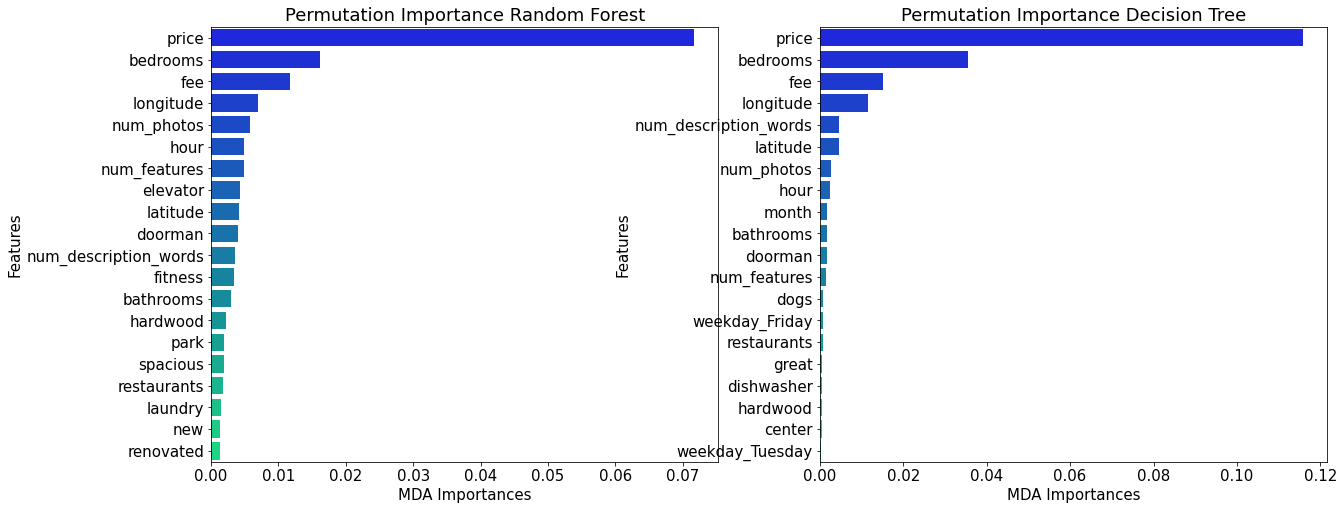

In [22]:
#plotting importances
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(x=feature_mda_top20_rf, y=feature_mda_top20_rf.index, palette='winter')
plt.xlabel('MDA Importances', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Permutation Importance Random Forest", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
sns.barplot(x=feature_mda_top20_dc, y=feature_mda_top20_dc.index, palette='winter')
plt.xlabel('MDA Importances', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Permutation Importance Decision Tree", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

As seen in the two graphs above, the top 3 features for both models are price, bedrooms and fee. Important in this regard means, that the 3 before mentioned features have the highest impact on the decision of the model how to predict. If we think about the Netflix example again and assume that the algorithm for recommendations takes more variables next to your watch history into account like the time you are searching for a film and actual trends in your country, it seems like the watch history was the most important for the Netflix recommendation, because it was based on the biased history from your sister and not on a current trend in you country (assuming that the trend maybe also was romance). So, the feature importance actually estimates to what extend a certain features will lead the model to a decision.

In our example it makes sense that price, bedrooms and the fee are very important for the prediction of the interest level. It is common sense that the price of a flat is one of the most important aspects to decide whether to rent the flat or not. Better said it also estimates whether one can afford the flat or not. While price might be the first thing to look at when deciding for a new flat, we claim that the size of the flat is the second important thing to look at when searching for a new flat. The number of bedrooms as the second highest feature importance leads to this thought of the size of the flat. There are typically two types of households that are related to the size of the flat and the number of bedrooms. Single and couple households usually only search for a flat with one bedroom, while families or flat mates search for more than one bedroom. With the number of bedrooms then also the size of the flat increases. Because the more bedrooms, the more people live in this flat and the more room is needed to host those people. The third most important feature in both models is the fee, which was created at the feature engineering part for the column feature. It is a bit surprising to us, because a fee might not be relatable to us when searching for a flat, which can be seen as personal bias. After a quick research we found out, that it is quite common in New York to pay a broker fee for a flat. Since it is also common sense that people tend to look a lot on the money, which can also be derived from the fact that price is the most important feature according to our models, it is also very important to know whether a fee has to be paid or not in order to decide whether to check out the flat or not.

Also important to us when searching for a flat is the location of it. Therefore, we put some effort into getting neighborhoods out of the longitude and latitude, because we thought that longitude and latitude only build a unique point in the map which is not as predictable as a neighborhood. Our idea was that a certain neighborhood is very popular or not and therefore is then predicting whether the interest level is high or low. Because a neighborhood is something where different points in a map can belong to, whereas longitude and latitude are only built one point in the map, which is unique and no other point can belong to. But surprisingly neighbourhoods are not even listed in the top 20 most important features for both models. Instead, longitude is listed as the 4th most important feature for both models. Even more surprisingly is that latitude is not next to longitude, but way less important in both models. After a brief look on the map of New York City it was easy to see, that it is rather a long city than a wide city. Also, when looking at the location of the districts of New York, it can be seen that they're rather located above and under each other than left and right from each other. Therefore, the longitude is revealing more information about the location or the district of the listing then the latitude and that could be why the model emphasizes longitude more than latitude.

As seen on the right figure for permutation importance for the decision tree, other than the 3 before mentioned features, no other features are really important for the prediction anymore. A slower decrease in feature importance for features after longitude can be seen on the left figure for premutation importance of the random forest. This means, that the random forest takes more different features into account for its prediction. One last feature in this regard to mention will be the feature num_photos which also seems to be important for the random forest. This makes sense to us since a listing for a flat seems to be more promising and more trustworthy to us, when there are pictures of the flat available.

# 5.2 PDP

**Explaining** **Predictions** for Random Forest and Decision tree

After looking at MDA feature importance, we are using the Partial Dependence Plot (PDP) to get a second opinion on the global feature importance. The goal of PDPs is to demonstrate how a particular feature affects the model's predictions. They offer a great insight into the relationship between features and the outcome. Therefore, we will look at the top features in both of the model and then compare the pdp graphs of those features in the two models. In this way, we can examine which model has what predicting value for a particular feature.

 **Feature 1: PRICE**

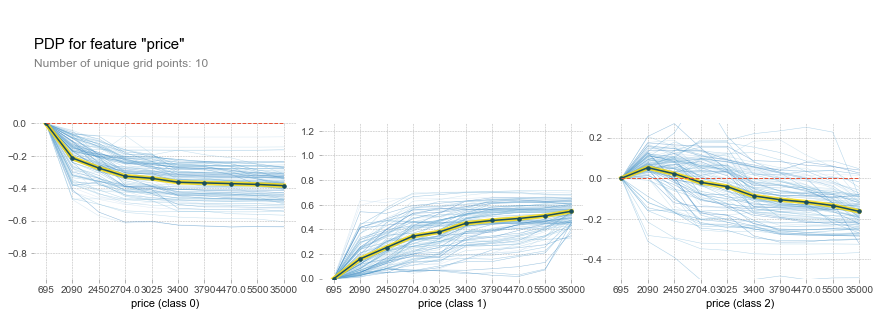

In [33]:
#Random forest

pdp_dist = pdp.pdp_isolate(model=rf3, dataset=x_test, model_features=x_test.columns, feature='price')
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_dist, feature_name='price', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)

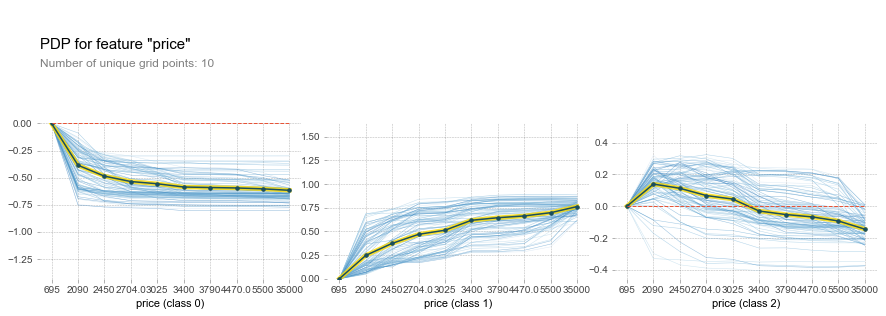

In [35]:
#Decision Tree
pdp_dist = pdp.pdp_isolate(model=DC2, dataset=x_test, model_features=x_test.columns, feature='price')
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_dist, feature_name='price', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)

**Findings for feature price**

- Class 0:  Interest level **Medium**
  If we compare both graphs, the price has less predicting capacity for class 0 (medium interest level). In both graphs
of class 0, the predicting value is below 0. However, the random forest has a higher prediction value than the decision tree when it predicts class 0. The graph also shows that the relationship between target (interest level) and the feature (price) is linear for class 0. 

- Class 1: Interest level **Low**
For predicting the value for Class 1, the price in both models has higher effect for predicting the outcome. For class1, the decision tree has higher effect in predicting the outcome than the random forest. As  class 1 depicts the low interest level, it makes sense that with a higher price, the model is predicting the interest level as low.
For class 2, both models have a quite a complex relationship between feature and target. With the price (monthly rent) $2,090, both models have the spike in predicting the target and then there is linear relationship after that. Until a certain price level, the feature is contributing in prediction the outcome but then the predicting value is low. This variation can show that there is an average price that the people are willing to pay. Hence, until that price the interest level grows and after that it declines again. 

- Class 2: Interest level **High**
As class 2 shows the high interest level, we can see that until the certain price the price feature is able to predict the interest level as high then there is a dip for predicting it as high because with the increase in the price, people will have less interest.

**Feature 2: BEDROOMS**

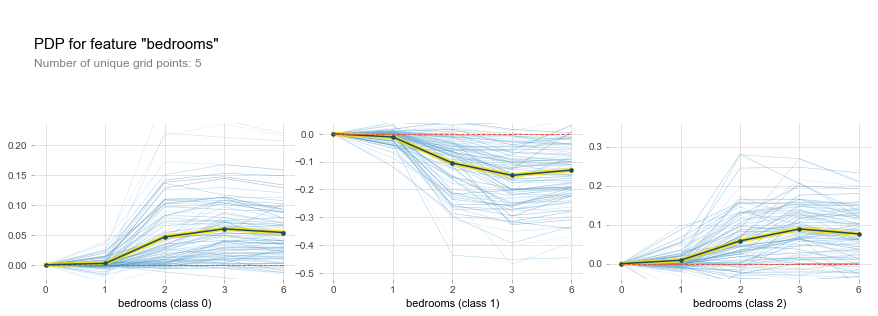

In [36]:
#Random forest

pdp_dist = pdp.pdp_isolate(model=rf3, dataset=x_test, model_features=x_test.columns, feature='bedrooms')
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_dist, feature_name='bedrooms', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)

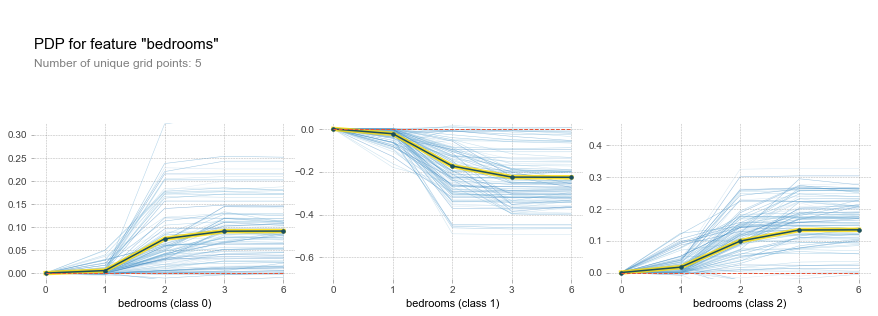

In [37]:
#Decision Tree
pdp_dist = pdp.pdp_isolate(model=DC2, dataset=x_test, model_features=x_test.columns, feature='bedrooms')
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_dist, feature_name='bedrooms', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)

**Findings for feature bedrooms** 
Overall, the decision tree has a higher predicting value for the number of bedrooms than the random forest.
The relationship between the number of bedrooms and its effect on predicting the interest level is complex.

- Class 0 (**Medium**):
 For the Random forest, we can see that the prediction capacity is at 0 with 0 and 1 bedrooms. The prediction value becomes higher and reaches its peak for 3 to 6 bedrooms.
 The graph looks similar for the Decision tree, however, the numbers are slightly higher, such that the predicting capacity for medium interest are higher for the decision tree than for the random forest.

- Class 1 (**Low**):
  Class 1 shows a low interest level in apartment advertisements. For 0 and 1 bedrooms the prediction capacity is around 0, but with increasing number of bedrooms it is decreasing even more. With more bedrooms the prediction value is decreasing for a low interest level.
  
- Class 2 (**High**):
The prediction of high interest from the number bedrooms has almost the same effect as for medium interest. If there are 2 to 6 bedrooms, the feature has more effect on predicting the outcome to be of high interest.
If an apartment has 2 or more bedrooms, the prediction value for high interest is also high.



**Feature 3: FEE**

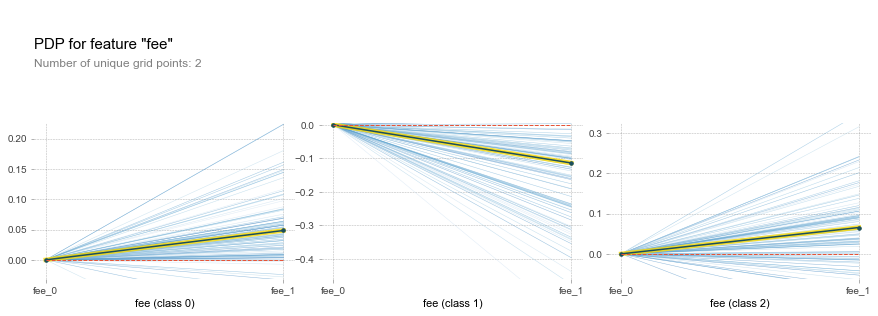

In [38]:
#Random forest

pdp_dist = pdp.pdp_isolate(model=rf3, dataset=x_test, model_features=x_test.columns, feature='fee')
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_dist, feature_name='fee', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)

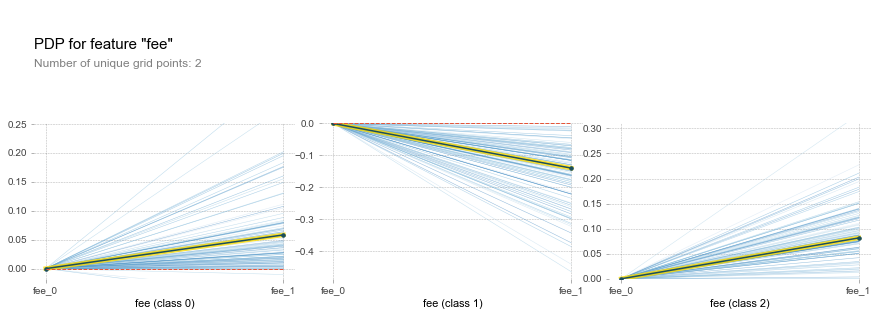

In [40]:
#Decision Tree
pdp_dist = pdp.pdp_isolate(model=DC2, dataset=x_test, model_features=x_test.columns, feature='fee')
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_dist, feature_name='fee', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)

**Findings for feature fee** 

Overall, both models have the same prediction capacity for the fee and both show a linear relationship.

- Class 0 (**Medium**):
 For both models, we can see that the prediction capacity is at 0 with no fee and higher for a fee, as fee is a categorical feature. If an apartment ad has a fee, it is better to predict a medium interest level.
 The graph looks similar for the Decision tree.

- Class 1 (**Low**):
  Class 1 shows a low interest level. If no fee is mentioned in the ad, the prediction capacity is at 0, because its cannot act as predictor. With mentioning a fee, the prediction is in the negative area. If an apartment ad has a fee, the low interest level ha low prediction power.
  
- Class 2 (**High**):
The prediction of high interest from the number of bedrooms has almost the same effect as for medium. If there is a fee, it has a higher effect on predicting the outcome as high.
If an apartment has a fee, the prediction value for high interest is also high.

After we got this global overview, we want to pick some example predictions and see whether our thoughts on the global MDA and PDP importance can be proven or if we see other interesting findings.

## 5.2 SHAP

**Random Forest**

In [45]:
row_to_show = 100 #decide for a row whose prediction will be shown in detail
data_for_prediction = x_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired!
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

print(rf3.classes_)
rf3.predict_proba(data_for_prediction_array) #predict the one specified row

['high' 'low' 'medium']


array([[0.028875  , 0.75978711, 0.21133789]])

As seen above, the prediction of the random forest for row 100 is that the interest level will be most likely 'low'. Because the outcome says, that the probability of the interest level to be high is 3%, to be low is 76% and to be medium is 21%. Let's have a look what data we passed into our random forest.

In [46]:
data_for_prediction

bathrooms                   1.0000
bedrooms                    3.0000
latitude                   40.7013
longitude                 -73.9261
price                    3500.0000
num_photos                 12.0000
num_features                8.0000
num_description_words      48.0000
hardwood                    0.0000
doorman                     0.0000
fee                         1.0000
cats                        1.0000
laundry                     0.0000
war                         0.0000
fitness                     0.0000
elevator                    0.0000
dishwasher                  0.0000
dogs                        1.0000
The Bronx                   0.0000
Lenox Hill                  0.0000
Queens                      0.0000
Stuy Town                   0.0000
Bay Ridge                   0.0000
Steinway                    0.0000
Sunset Park                 0.0000
Upper West Side             0.0000
Gramercy                    0.0000
Park Slope                  0.0000
new                 

Now we will use SHAP in order to see how this prediction was done or better said how the features above led to this prediction.

In [47]:
# Create object that can calculate shap values and assign model to it
explainer = shap.TreeExplainer(rf3)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [48]:
#plot SHAP value visualization
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

The graph above shows how the features influenced the random forest to come up with a probability of 76% for the interest level to be low. The red bars in this graph show to what extend the features increased the probability for the interest level to be low and the blue bars show what acutally decreased the probability. Let's discuss this for some picked features in order to understand what this actually means.

Let's have a look on the price feature, which was stated to be the most important feature in the global analysis. As seen in the graph above, also here the price has the highest impact for the prediction. Since it is marked red, it means that the price increased the probability for the interest level to be low, which means that a price of 3,500 seems to be rather high and therefore does not attract so many people. Related to the price is mostly the size of the apartment. As described before, an indicator for the size of the departments is the number of bedrooms. In this specific example it can be seen that the number of bedrooms is rather high with a count of 3. Therefore, the flat seems to be bigger and a higher price might be reasonable. Therefore, bedrooms is marked blue, so it is decreasing the probability of the interest level to be low. Which means the numbers of bedrooms to some extend is relativizing the price. 

Having a closer look into what lowered the probability of the prediction of the interest level to be low in the graph shows, that the weekday and the time had a noticeable impact. Which means that Friday around 11 seems to be actually a good time to put rental listings online. Moreover, the fact that the word spacious was somehow used in the description of the listing decreased the chance of the listing to have a low interest level, which actually means that spacious apartments seem to have a medium or high interest level.

Also mentioned in the global analysis of feature importance was that the location seems to be important for the interest level. In this specific case, surprisingly latitude was more important than longitude. However, both had almost the same feature importance as it can be seen in the table below and both were leading to the prediction that the interest level should be low. This means that the location is not very popular. This can be actually proven by having a look into the data that we've passed to the explainer, which was shown some code cells above. It can be seen that none of the popular neighborhoods are marked with a 1. Therefore, this listing seems to be in a rather unpopular location. Moreover, it can be seen that the fact that there are no hardwood floors, that there is no laundry in the building and that it is not renovated led to an increase in the prediction of the interest level to be low. This actually makes sense to us.

In [49]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_test.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(20)

,col_name,feature_importance_vals
4,price,0.066582
1,bedrooms,0.026137
2,latitude,0.023017
3,longitude,0.022685
41,hour,0.017842
42,weekday_Friday,0.013324
8,hardwood,0.013062
34,spacious,0.009655
12,laundry,0.007270
29,renovated,0.007010


**Decision Tree**

Let's do this same procedure with the same data for the Decision Tree!

In [50]:
row_to_show = 100 #decide for a row whose prediction will be shown in detail
data_for_prediction = x_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired!
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

print(DC2.classes_)
DC2.predict_proba(data_for_prediction_array) #predict the one specified row

['high' 'low' 'medium']


array([[0.03274515, 0.81484436, 0.1524105 ]])

As seen above, the prediction of the decision tree for row 100 is that the interest level will be most likely 'low'. Because the outcome says, that the probability of the interest level to be high is 4%, to be low is 80% and to be medium is 16%.

Now we will use SHAP in order to see how this prediction was done or better said how the features above led to this prediction.

In [51]:
# Create object that can calculate shap values and assign model to it
explainer = shap.TreeExplainer(DC2)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [52]:
#plot SHAP value visualization
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Same as for the random forest, the decision tree predicts a low interest in this listing. But this time, the probability is approx. 4% higher, which means that the decision tree is more confident with its decision for the interest level of this listing to be low. As already seen for the random forest also for the decision tree price, bedrooms, latitude, longitude, hardwood, laundry and hour have the same direction of impact to this prediction. But a look into the table below shows that the values of the feature importance have changed in comparison to the random forest. While bedroom had the second highest feature importance in the prediction of the random forest, it is longitude for the decision tree. It can also be seen that here longitude is double of the feature importance of latitude, which leads back to what we've seen in the global feature importance for both models. For this, we actually have no logical explanation and for the first time raise the thought, that longitude and latitude might not have a good predicting power, but are high ranked, because they're an numerical value. However, until this point and due to the limited given time, we could not prove this thought.

Also, interesting to see is that there are two new features mentioned in the graph above, that were not mentioned in the graph for the random forest. The number of words in the description with a count of 48 seems to be rather low since it increases the prediction of the level of interest to be low. Because our assumption is that rather long and detailed descriptions increase the interest level. We're actually happy to see that the fee now also shows up in the SHAP graph above, because it was mentioned to be the 3rd most important feature in the global feature importance analysis. Since fee is marked with a 1, this word is included in the column features. Because most of the entries in this column that have the word fee inside are "no fee", it means that fee should increase the interest level when included. We're glad to see that this is the case in our example above. Because fee is marked to lower the prediction of the interest level to be low in this case.

In [53]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_test.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(20)

,col_name,feature_importance_vals
4,price,0.062602
3,longitude,0.057719
1,bedrooms,0.043435
2,latitude,0.024933
8,hardwood,0.019565
10,fee,0.014885
41,hour,0.009326
7,num_description_words,0.007301
5,num_photos,0.005172
12,laundry,0.004426


All in all we conclude that we trust our models, because we could verify the predictions and feature importance of our models with common human knowledge and a little research about the city New York. For SHAP we checked more than the shown prediction and could not find any suspicious prediction. Therefore, all predictions are logical to us. 

Due to the limited time we were not able to improve our model performance. Therefore, we think that there is room for improvement in this regard. Nevertheless, the focus was on interpretable machine learning and that is why we decided to spent most of our time with implementing all our initial ideas while explaining every step as thoroughly as possible. In the end we're very happy to say that we've learned a lot and deepend our knowledge in machine learning.